In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [57]:
from langchain_community.tools import WolframAlphaQueryRun

In [4]:
tool = TavilySearchResults(max_results=2)

print(type(tool))

print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


This name is the one which the llm will use to call this tool

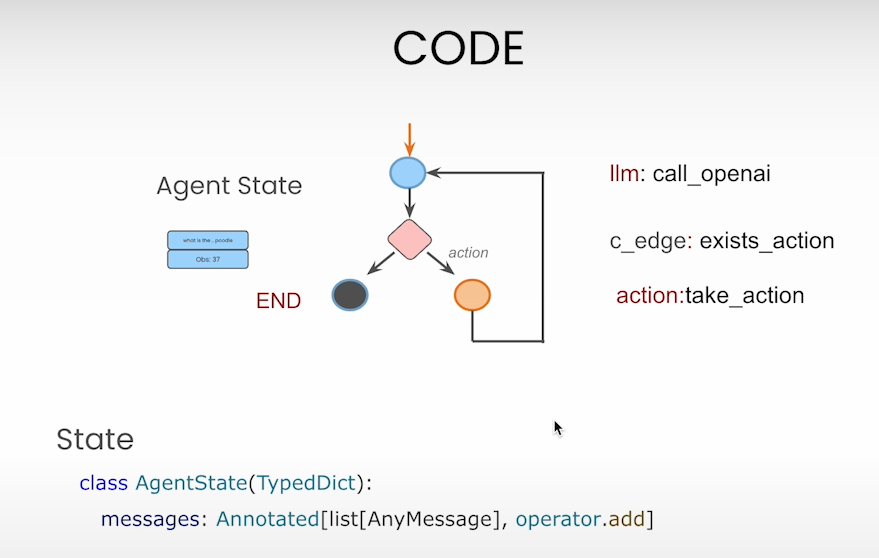

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    
    #this is the state of the agent at any time
    #just a list of annotated messages which we'll add over time

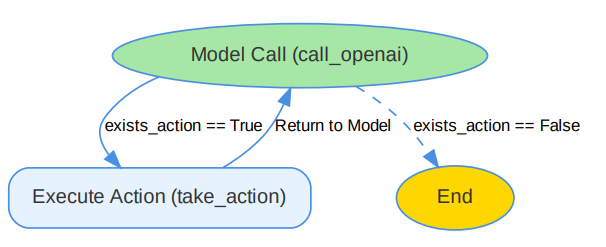

In [7]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        
        graph = StateGraph(AgentState)
        #we start creating the graph representing the agent
        
        graph.add_node("llm", self.call_openai)
        
        graph.add_node("action", self.take_action)
        #we add node ("name", function_to_do)
        
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            #if exists a called tool, == go to action NODE, if not, END
            {True: "action", False: END}
            
        )#1. we make the link between the llm and the action node
        
        graph.add_edge("action", "llm")
        #2. we make the other backwards connection between the action and the llm
        
        graph.set_entry_point("llm")
        
        self.graph = graph.compile() #compiling the graph
        self.tools = {t.name: t for t in tools} #dict of the tool name, tool itself
        self.model = model.bind_tools(tools) #giving the tools to the model

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        #we'll get here the current list of messages oof the model
        
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
            #we'll add in the system message
            
        #given that system message and the previous message(s), we run the model
        message = self.model.invoke(messages)
        return {'messages': [message]} #we return the new answer of the llm

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        #the model must have wanted to call some tools
        
        #so we retrieve the last message from the agent (its answer)
        #we access the referenced tool with the attribute tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

Note: in take_action below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [8]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

In [19]:
from IPython.display import Image

# Image(abot.graph.get_graph().draw_png())

In [15]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


- El agente empieza en `llm`, donde pregunta al modelo si hay alguna acción para realizar

> Si hay una acción, va a `action` y la ejecuta

> Si no hay ninguna acción, el flujo llega a `END` y termina

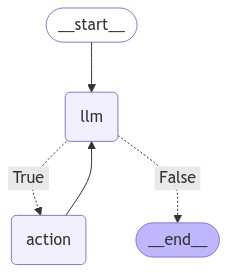

In [18]:
display(
    Image(
        abot.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In this agent, we simply have this logic:

    - The agent starts in llm (executes the model given the prompt) call_openai()

    - Then it asks the if there's any action the llm wants to call

    Ø In case there's an action(s), goes to the action and it executes it (take_action())
    
If not, the flow goes to END

In [20]:
messages = [HumanMessage(content="What's the weather in sf?")]

result = abot.graph.invoke({"messages":messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_nM2GC6NJdfO0v6DtEGpGYshu', 'type': 'tool_call'}
Back to the model!


In [22]:
result["messages"][-1]

AIMessage(content='The current weather in San Francisco is 57.5°F with light rain showers. The wind speed is 11.9 mph coming from the west. The humidity is at 79%, and the visibility is 6.0 miles.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 706, 'total_tokens': 755, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-2e30467c-f49d-4aea-a88e-d453f38c4d7d-0', usage_metadata={'input_tokens': 706, 'output_tokens': 49, 'total_tokens': 755, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [43]:
messages = [HumanMessage(content="who is Donald Trump? Make a comparison of him with Donald Duck of Disney \
    .Go ahead and make a funny haiku about both")]

result = abot.graph.invoke({"messages":messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Donald Trump'}, 'id': 'call_5y1E2Pb6TdrKTYF09sxNduQ3', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Donald Duck'}, 'id': 'call_umeEzg3JkCw7o7GlB3GJJHZj', 'type': 'tool_call'}
Back to the model!


In [44]:
print(result["messages"][-1].content)

Donald Trump is a former president facing federal charges, including obstruction of justice and false statements. On the other hand, Donald Duck is an ill-tempered cartoon duck created by Walt Disney, known for his angry outbursts and unique voice.

Now, let's create a funny haiku about both Donald Trump and Donald Duck:

Donald Trump in the news,
Quacking like Donald Duck does,
Comedy ensues.


In [45]:
messages = [HumanMessage(content="Who is YannLeCun?. Make a bullet point comparison between him and Marie curie \
    .Then Go ahead and make a funny haiku of them")]

result = abot.graph.invoke({"messages":messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Yann LeCun'}, 'id': 'call_6NMYTDuW8NMT1LBusmf30t4t', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Marie Curie'}, 'id': 'call_ZQVClwQjr29TuL3QjtL3kull', 'type': 'tool_call'}
Back to the model!


In [53]:
for message in result["messages"]:
    
    print(type(message))

<class 'langchain_core.messages.human.HumanMessage'>
<class 'langchain_core.messages.ai.AIMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.tool.ToolMessage'>
<class 'langchain_core.messages.ai.AIMessage'>


In [56]:
for message in result["messages"]:
    
    print(type(message), message.content)

<class 'langchain_core.messages.human.HumanMessage'> Who is YannLeCun?. Make a bullet point comparison between him and Marie curie     .Then Go ahead and make a funny haiku of them
<class 'langchain_core.messages.ai.AIMessage'> 
<class 'langchain_core.messages.tool.ToolMessage'> [{'url': 'https://engineering.nyu.edu/faculty/yann-lecun', 'content': 'Yann LeCun is a professor and director of AI research at Facebook, and a Silver Professor of Data Science, Computer Science, Neural Science, and Electrical Engineering at NYU. He works on AI, machine learning, computer vision, robotics, and image compression.'}, {'url': 'https://scholar.google.com/citations?user=WLN3QrAAAAAJ', 'content': 'Yann LeCun. Chief AI Scientist at Facebook & Silver Professor at the Courant Institute, New York University. Verified email at cs.nyu.edu - Homepage. AI machine learning computer vision robotics image compression. Title.'}]
<class 'langchain_core.messages.tool.ToolMessage'> [{'url': 'https://www.nobelprize.